Original candidates= (500, 5)
Reduced candidates to 180 promising ones using SVM.
Reduced candidates= (180, 5)
first point ei_vals[ 23 ]= 0.07094771135970013
seed_points=
 [[0.46593324 0.09208897 0.63175219 0.61638379 0.03208135]
 [0.35786806 0.21124594 0.65437651 0.64037011 0.04710578]
 [0.46838087 0.1628953  0.87337914 0.4258655  0.01971124]
 [0.23662399 0.03506344 0.77020892 0.95035466 0.22624786]
 [0.46308204 0.48076548 0.32475525 0.78648528 0.05482673]
 [0.48520396 0.3762973  0.62309379 0.49845958 0.0369597 ]
 [0.58194114 0.07164854 0.62167045 0.75221493 0.14185321]
 [0.31858113 0.56098793 0.21864138 0.91688292 0.04430292]
 [0.09849021 0.02723247 0.52145043 0.75496095 0.13076187]
 [0.06757303 0.30218831 0.447821   0.92920552 0.05197272]]
seed=	 [0.46593324 0.09208897 0.63175219 0.61638379 0.03208135] 	EI= 0.10333950383794038
best_x=	 [0.41003554 0.         0.68501759 0.76464712 0.        ] 	EI= 0.10333950383794038
seed=	 [0.35786806 0.21124594 0.65437651 0.64037011 0.04710578] 	EI

2025-11-11 08:15:40.018869: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


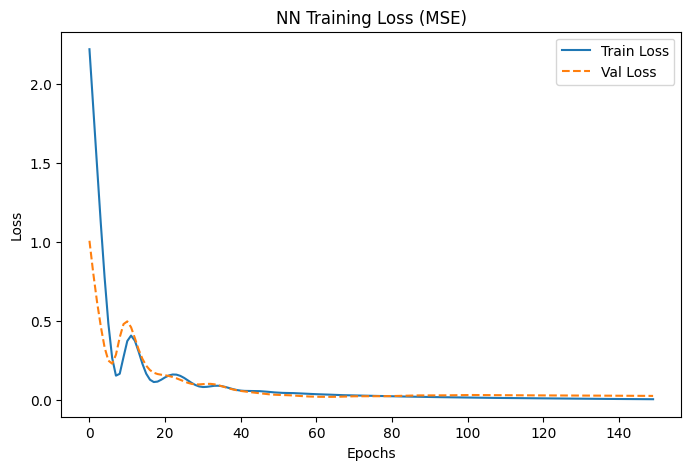

Skipping 2D visualization (inputs not 2D)

Performing gradient-based query selection...
Next suggested query point (based on gradient direction): 0.924485-0.247959-0.127727-0.172451-0.057847  


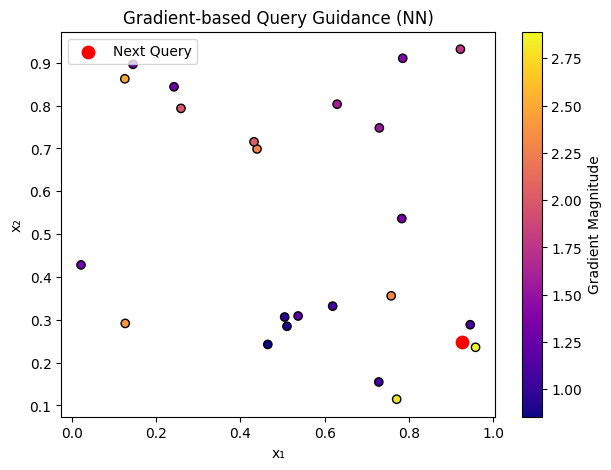


✅ Model run complete.


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import norm
from scipy.optimize import minimize
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Fix seeds for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Make TensorFlow deterministic (optional, depends on hardware)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ------------------------------------------------------------
# Load initial data
# ------------------------------------------------------------
X = np.load("initial_inputs.npy")        # shape (n0, d)
y = np.load("initial_outputs.npy")       # shape (n0,)

# ------------------------------------------------------------
# Append new information
# ------------------------------------------------------------
X = np.append(X,[[0.464910, 0.242338, 0.574751, 1.000000, 0.000000]], axis=0)  # Append week1 inputs
y = np.append(y, -0.48648514318802477)         # Append week1 outputs

X = np.append(X,[[0.510340, 0.284791, 0.749903, 1.000000, 0.217215]], axis=0)  # Append week2 inputs
y = np.append(y, -0.7074155857201168)          # Append week2 outputs

X = np.append(X,[[0.504917, 0.306407, 0.358712, 0.842651, 0.000000]], axis=0)  # Append week3 inputs
y = np.append(y, -0.5293588213594093)          # Append week3 outputs

X = np.append(X,[[0.925552, 0.249438, 0.127394, 0.173302, 0.057026]], axis=0)  # Append week4 inputs
y = np.append(y, -1.7332301250841522)          # Append week4 outputs


# ------------------------------------------------------------
# Normalise inputs and outputs
# ------------------------------------------------------------
x_scaler = StandardScaler()
Xn = x_scaler.fit_transform(X)

y_mean = y.mean()
y_std = y.std() if y.std() > 0 else 1.0
yn = (y - y_mean) / y_std                 # GP works better with normalized target


def visualize_iteration(Xn, seed_points, suggested_point):
    """
    Simple 2D visualization of current iteration:
    - Xn: existing normalized input data (n x 2)
    - seed_points: candidate points used for local optimization (m x 2)
    - suggested_point: final chosen query point (1 x 2)
    """
    if Xn.shape[1] != 2:
        print("This visualization works only for 2D input data.")
        return

    plt.figure(figsize=(8, 6))
    plt.scatter(Xn[:, 0], Xn[:, 1], c='blue', label='Existing points', s=40, alpha=0.7)
    plt.scatter(seed_points[:, 0], seed_points[:, 1], c='orange', label='Seed points', s=50, alpha=0.7, edgecolors='k')
    plt.scatter(suggested_point[0], suggested_point[1], c='red', label='Suggested point', s=120, marker='*', edgecolors='k')

    plt.title("Bayesian Optimization Progress (2D)")
    plt.xlabel("Feature 1 (normalized)")
    plt.ylabel("Feature 2 (normalized)")
    #plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_svm(Xn, yn, candidates_raw, good_candidates_raw,
                  suggested_point, svm_clf, x_scaler):
    """
    Plot the SVM decision boundary together with:
      • all random candidates (gray)
      • candidates kept by SVM (orange)
      • existing data (blue)
      • final suggestion (red star)
    """
    if Xn.shape[1] != 2:
        print("SVM visualisation works only for 2-D inputs.")
        return

    # Create a dense grid for the contour
    h = 0.01
    x_min, x_max = Xn[:,0].min(), Xn[:,0].max()
    y_min, y_max = Xn[:,1].min(), Xn[:,1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = svm_clf.decision_function(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(9,7))
    # Decision boundary
    plt.contourf(xx, yy, Z, levels=[-np.inf,0,np.inf],
                 colors=['#FFDDDD','#DDFFDD'], alpha=0.3)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

    # All random candidates
    plt.scatter(candidates_raw[:,0], candidates_raw[:,1],
                c='lightgray', s=15, alpha=0.6, label='All random candidates')

    # Candidates kept by SVM
    plt.scatter(good_candidates_raw[:,0], good_candidates_raw[:,1],
                c='orange', s=40, edgecolor='k', label='SVM-filtered candidates')

    # Existing points (colour-coded by class for reference)
    median_y = np.median(yn)
    colors = np.where(yn >= median_y, 'blue', 'cyan')
    plt.scatter(Xn[:,0], Xn[:,1], c=colors, s=80,
                edgecolor='k', label='Existing points (≥/ < median)')

    # Suggested point
    plt.scatter(suggested_point[0], suggested_point[1], c='red',
                s=150, marker='*', edgecolor='k', label='Suggested point')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("SVM Decision Boundary + Candidate Filtering")
    plt.xlabel("Feature 1 (norm.)")
    plt.ylabel("Feature 2 (norm.)")
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Define helper: visualize function surface
# -------------------------------
def plot_surface(X, y, model, title, model_type):
    if X.shape[1] != 2:
        print("Skipping 2D visualization (inputs not 2D)")
        return

    x1 = np.linspace(X[:, 0].min()-0.25, X[:, 0].max()+0.25, 100)
    x2 = np.linspace(X[:, 1].min()-0.25, X[:, 1].max()+0.25, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    grid = np.c_[xx1.ravel(), xx2.ravel()]

    if model_type == "nn":
        y_pred = model.predict(grid)
    else:
        y_pred = model.predict(grid)

    y_pred = y_pred.reshape(xx1.shape)

    plt.figure(figsize=(7, 6))
    contour = plt.contourf(xx1, xx2, y_pred, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", label="Training points")
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.colorbar(contour)
    plt.legend()
    plt.show()

# ------------------------------------------------------------
# Fit a Gaussian Process surrogate
# ------------------------------------------------------------
d = X.shape[1]
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(d),
                                      length_scale_bounds=(1e-5, 1e5),
                                      nu=2.5)
kernel += WhiteKernel(noise_level=1e-6,
                      noise_level_bounds=(1e-10, 1e1))

gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=False,
                              n_restarts_optimizer=10,
                              random_state=0)
gp.fit(Xn, yn)

# ------------------------------------------------------------
# Add SVM to classify promising regions
# ------------------------------------------------------------
if len(yn) > 1:  # need at least two points for classification
    median_y = np.median(yn)
    labels = (yn >= median_y).astype(int)
    svm_clf = SVC(kernel='rbf', C=1.0)
    svm_clf.fit(Xn, labels)
else:
    svm_clf = None

# ------------------------------------------------------------
# Define Expected Improvement acquisition (for maximization)
# ------------------------------------------------------------
f_best = yn.max()
xi = 0.01     # exploration parameter

def predict_raw(x_raw):
    """Predict mean and std in normalized GP space for a raw input x_raw."""
    x = np.atleast_2d(x_raw)
    xn = x_scaler.transform(x)
    mu, sigma = gp.predict(xn, return_std=True)
    return mu.ravel(), sigma.ravel()

def expected_improvement_raw(x_raw, xi=xi):
    """Compute EI for a raw input x_raw."""
    mu, sigma = predict_raw(x_raw)
    sigma = np.maximum(sigma, 1e-9)       # avoid division by zero
    z = (mu - f_best - xi) / sigma
    ei = (mu - f_best - xi) * norm.cdf(z) + sigma * norm.pdf(z)
    #print ("x_raw=", x_raw, "mu=", mu, "sigma=", sigma,"ei=",ei)
    return ei.ravel()[0]

# ------------------------------------------------------------
# Search for the next query point
# ------------------------------------------------------------
# Domain is assumed to be [0,1]^d (based on inspection of initial data)
bounds = [(0.0, 1.0)] * d

# Global random search to find good seeds
n_seeds = 500
rng = np.random.default_rng(1)
# Need to decide where the random points needs to be
candidates_raw = rng.uniform(0.0, 1.0, size=(n_seeds, d))


print ("Original candidates=", candidates_raw.shape)
good_candidates_raw = candidates_raw.copy()

if svm_clf is not None:
    candidates_n = x_scaler.transform(candidates_raw)
    predicted_labels = svm_clf.predict(candidates_n)
    good_idx = np.where(predicted_labels == 1)[0]
    if len(good_idx) > 0:
        good_candidates_raw = candidates_raw[good_idx]
        print(f"Reduced candidates to {len(good_candidates_raw)} promising ones using SVM.")

print ("Reduced candidates=", good_candidates_raw.shape)

# ---- EI evaluation on the (possibly reduced) candidate set ----
ei_vals = np.array([expected_improvement_raw(c) for c in good_candidates_raw])
best_idx = np.argmax(ei_vals)
print ("first point ei_vals[",best_idx,"]=", ei_vals[best_idx])

# ---- Take top-10 seeds for local optimisation ----
seed_points = good_candidates_raw[np.argsort(-ei_vals)[:10]]
print ("seed_points=\n", seed_points)

best_x = None
best_val = -1.0
for s in seed_points:
    res = minimize(lambda xx: -expected_improvement_raw(xx),
                   x0=s,
                   bounds=bounds,
                   method="L-BFGS-B",
                   options={'maxiter':300})
    if res.success:
        val = -res.fun
        print ( "seed=\t", s, "\tEI=", val)
        #visualize_iteration(Xn, seed_points, best_x)
        if val > best_val:
            best_val = val
            best_x = res.x.copy()
            print ( "best_x=\t", best_x, "\tEI=", val )
        
        

# Fallback if optimizer fails
if best_x is None:
    best_x = good_candidates_raw[best_idx]
    best_val = ei_vals[best_idx]

# ------------------------------------------------------------
# Report results
# ------------------------------------------------------------
suggested_point = np.atleast_1d(best_x)
mu_s, sigma_s = predict_raw(suggested_point.reshape(1, -1))

# Convert mean/std back to original y-scale
mu_orig = mu_s * y_std + y_mean
sigma_orig = sigma_s * y_std
next_query = "-".join([f"{xi:.6f}" for xi in suggested_point])

print("Suggested next query point (raw input space):", next_query)
print("Expected Improvement at this point (normalized):", best_val)
print("GP predicted mean at this point (original y scale):", mu_orig)
print("GP predicted stddev at this point (original y scale):", sigma_orig)

# Visualise 1. Standard BO progress plot
visualize_iteration(X, seed_points, best_x)

# 2. SVM decision-boundary plot (only when SVM was trained)
if svm_clf is not None:
    visualize_svm(X, y,
                  candidates_raw,
                  good_candidates_raw,
                  best_x,
                  svm_clf,
                  x_scaler)



# -------------------------------
# Model 4: Neural Network (Keras)
# -------------------------------
    model_type = "nn"
    # Build NN
    def build_nn(input_dim):
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                      loss='mse')
        return model

    nn_model = build_nn(X.shape[1])

    # Train NN
    history = nn_model.fit(X, y, epochs=150, batch_size=None, validation_split=0.2, verbose=0)

    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
    plt.title("NN Training Loss (MSE)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot surface
    plot_surface(X, y, nn_model, "Neural Network Surrogate", model_type)

    # -------------------------------
    # Gradient-based Next Query Selection
    # -------------------------------
    print("\nPerforming gradient-based query selection...")

    # Convert X to tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    X_tensor = tf.Variable(X_tensor)

    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        preds = nn_model(X_tensor)
    grads = tape.gradient(preds, X_tensor).numpy()
    grad_norm = np.linalg.norm(grads, axis=1)
    max_grad_idx = np.argmax(grad_norm)
    next_query = X[max_grad_idx] + 0.05 * grads[max_grad_idx] / grad_norm[max_grad_idx]
    suggested_point = "-".join([f"{xi:.6f}" for xi in next_query])
    print(f"Next suggested query point (based on gradient direction): {suggested_point}  ")

    # Visualize gradient magnitude
    plt.figure(figsize=(7, 5))
    plt.scatter(X[:, 0], X[:, 1], c=grad_norm, cmap='plasma', edgecolors='k')
    plt.colorbar(label='Gradient Magnitude')
    plt.title("Gradient-based Query Guidance (NN)")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.scatter(next_query[0], next_query[1], color='red', s=80, label='Next Query')
    plt.legend()
    plt.show()

else:
    raise ValueError(f"Unknown model_type: {model_type}")

print("\n✅ Model run complete.")    